1.IMPORTS

In [14]:
import kagglehub
ruvelpereira_mit_plagairism_detection_dataset_path = kagglehub.dataset_download('ruvelpereira/mit-plagairism-detection-dataset')

print('Data source import complete.')

Data source import complete.


In [16]:
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Subtract
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

import re
import nltk
import spacy
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

Converting Text file to csv

In [17]:
# robust_read_and_make_csv.py
import os
import csv
from glob import iglob
import pandas as pd

TARGET_FILENAME = "train_snli.txt"
ALT_FILENAMES = ["train_snli.txt", "train_snli.tsv", "train.txt", "train_snli.csv"]

def find_file(filename_candidates, search_roots=None):
    """Search recursively for any of filename_candidates under search_roots.
       Returns first full path found or None."""
    if search_roots is None:
        search_roots = ['/kaggle/input', '/mnt/data', '.']
    for root in search_roots:
        if not os.path.exists(root):
            continue
        # Use iglob to avoid building huge lists
        for cand in filename_candidates:
            pattern = os.path.join(root, '**', cand)
            for path in iglob(pattern, recursive=True):
                if os.path.isfile(path):
                    return os.path.abspath(path)
    return None

def try_kaggle_download(dataset_slug, download_to="/mnt/data/mit_plagiarism"):
    """Try to download dataset using kaggle API if available and configured.
       Requires kaggle package and ~/.kaggle/kaggle.json credentials."""
    try:
        import kaggle
        os.makedirs(download_to, exist_ok=True)
        print(f"Attempting to download dataset {dataset_slug} to {download_to} using kaggle API...")
        kaggle.api.dataset_download_files(dataset_slug, path=download_to, unzip=True, quiet=False)
        print("Download/unzip complete.")
        return download_to
    except Exception as e:
        print("Kaggle download failed or Kaggle not configured:", repr(e))
        return None

def read_and_write_csv(input_path, output_csv="data.csv"):
    rows = []
    with open(input_path, 'r', encoding='utf-8', errors='replace') as f:
        for i,line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            # Many plagiarism datasets use tab-separated pairs with a label
            # We'll try tab split first, then comma, then fallback
            parts = line.split('\t')
            if len(parts) < 3:
                parts = line.split(',')
            if len(parts) < 3:
                # fallback: try splitting into 2 parts (source and plag) and default label to 1
                # or skip if not parseable
                # attempt to split on '|||' or ' <-> ' patterns (common in some datasets)
                if '|||' in line:
                    parts = line.split('|||')
                elif ' <-> ' in line:
                    parts = line.split(' <-> ')
            if len(parts) >= 3:
                src = parts[0].strip()
                plag = parts[1].strip()
                try:
                    label = int(parts[2])
                except:
                    # If label not integer, try to sanitize
                    label = 1 if parts[2].strip() in ('1','true','True','plagiarized') else 0
                rows.append({'source_txt': src, 'plagiarism_txt': plag, 'label': label})
            else:
                # could be a csv row already
                # try using pandas to parse one line
                # skip lines that are not parseable
                print(f"Warning: skipping unparsable line {i+1}: {line[:100]}...")
                continue

    if not rows:
        raise RuntimeError("No rows parsed from file. Check file format.")
    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False, encoding='utf-8')
    print(f"Wrote {len(df)} rows to {output_csv}")
    return output_csv

if __name__ == "__main__":
    # 1) try to find the file
    found = find_file(ALT_FILENAMES, search_roots=['/kaggle/input', '/mnt/data', '.'])
    if found:
        print("Found file:", found)
        out = read_and_write_csv(found, output_csv="data.csv")
    else:
        print("File not found in common locations.")
        # 2) attempt kaggle download (only if user has kaggle credentials configured)
        kaggle_slug = "ruvelpereira/mit-plagairism-detection-dataset"  # adjust if necessary
        download_path = try_kaggle_download(kaggle_slug)
        if download_path:
            # search again inside download_path
            found = find_file(ALT_FILENAMES, search_roots=[download_path])
            if found:
                print("Found file after kaggle download:", found)
                out = read_and_write_csv(found, output_csv="data.csv")
            else:
                print("Download succeeded but expected file not found under", download_path)
                print("Files under the download folder:")
                for root, dirs, files in os.walk(download_path):
                    for file in files[:50]:
                        print(os.path.join(root, file))
                raise FileNotFoundError("train_snli.txt not present in downloaded archive; inspect listing above.")
        else:
            # 3) final fallback: show helpful guidance and list /kaggle/input contents if any
            print("\n--- Diagnostic: listing '/kaggle/input' (if present) ---")
            if os.path.exists('/kaggle/input'):
                for entry in os.listdir('/kaggle/input'):
                    print(entry)
            raise FileNotFoundError(
                "Could not find train_snli.txt. If you downloaded the Kaggle dataset manually, "
                "place the dataset folder in the notebook environment (e.g. under /kaggle/input or current working dir), "
                "or configure Kaggle API credentials and try again. "
                "Dataset link: https://www.kaggle.com/datasets/ruvelpereira/mit-plagairism-detection-dataset"
            )


Found file: /content/train_snli.txt
Wrote 367373 rows to data.csv


In [18]:
df = pd.read_csv("/content/data.csv")
df.head()

,source_txt,plagiarism_txt,label
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [19]:
df.duplicated().sum()

np.int64(454)

In [20]:
df.drop_duplicates(inplace=True)

BASIC CLEANING

In [21]:
import re, string


def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #Replace newlines with spaces
    text = text.translate(str.maketrans("", "", string.punctuation)) #Remove punctuation
    return text


# Apply cleaning
df["source_clean"] = df["source_txt"].astype(str).apply(clean_text)
df["plag_clean"] = df["plagiarism_txt"].astype(str).apply(clean_text)

TOKENIZATION

In [22]:
source = df['source_clean'].tolist()
plag = df['plag_clean'].tolist()
labels = df['label'].values


tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(source + plag)


source_seq = tokenizer.texts_to_sequences(source)
plag_seq = tokenizer.texts_to_sequences(plag)


max_len = 50
source_pad = pad_sequences(source_seq, maxlen=max_len)
plag_pad = pad_sequences(plag_seq, maxlen=max_len)

SPLIT DATA

In [23]:
X_train_src, X_test_src, X_train_plag, X_test_plag, y_train, y_test = train_test_split(
source_pad, plag_pad, labels, test_size=0.2, random_state=42)

BUILD LSTM MODEL

In [11]:
#Siamese LSTM network

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
lstm_dim = 64

input_a = Input(shape=(max_len,))
input_b = Input(shape=(max_len,))

embedding = Embedding(vocab_size , embedding_dim , input_length = max_len)
lstm = LSTM(lstm_dim)

encoded_a = lstm(embedding(input_a))
encoded_b = lstm(embedding(input_b))

merged = Subtract()([encoded_a , encoded_b])
merged = Dense(64 , activation = "relu")(merged)
merged = Dropout(0.5)(merged)
out = Dense(1,activation="sigmoid")(merged)

model = Model(inputs=[input_a , input_b], outputs=out)
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  3,874,432 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 64)        │          0 │ lstm[0][0],       │
│                     │                   │            │ lstm[1][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,928,065 (14.98 MB)

 Trainable params: 3,928,065 (14.98 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)


TRAIN MODEL

In [13]:
history = model.fit(
    [X_train_src, X_train_plag],
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 94s 12ms/step - accuracy: 0.7408 - loss: 0.5004 - val_accuracy: 0.8349 - val_loss: 0.3683
Epoch 2/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - accuracy: 0.8523 - loss: 0.3414 - val_accuracy: 0.8530 - val_loss: 0.3394
Epoch 3/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - accuracy: 0.8811 - loss: 0.2878 - val_accuracy: 0.8626 - val_loss: 0.3287
Epoch 4/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 85s 12ms/step - accuracy: 0.8997 - loss: 0.2494 - val_accuracy: 0.8623 - val_loss: 0.3420
Epoch 5/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - accuracy: 0.9132 - loss: 0.2184 - val_accuracy: 0.8619 - val_loss: 0.3672


EVALUATION

In [14]:
pred = model.predict([X_test_src, X_test_plag])
pred_label = (pred > 0.5).astype(int)


print("Accuracy:", accuracy_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

2294/2294 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Accuracy: 0.8623541916494059
              precision    recall  f1-score   support

           0       0.89      0.82      0.86     36778
           1       0.84      0.90      0.87     36606

    accuracy                           0.86     73384
   macro avg       0.86      0.86      0.86     73384
weighted avg       0.86      0.86      0.86     73384



PLOT TRAINING CURVES

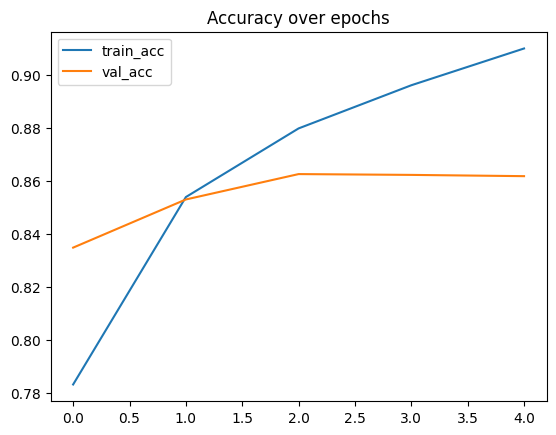

In [15]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

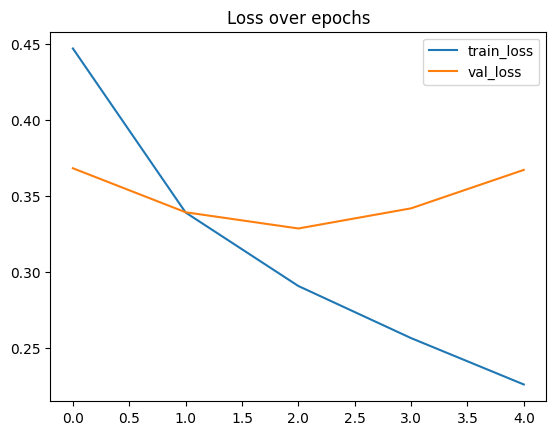

In [16]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

SAMPLE PREDICTION

In [17]:
idx = 0
src = X_test_src[idx:idx+1]
plg = X_test_plag[idx:idx+1]
print("Pred:", model.predict([src, plg])[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Pred: 0.75617605


Testing Model on User Inputs

In [18]:
def predict_pair(source_text, plag_text, tokenizer, max_len):
    # Convert to sequences
    src_seq = tokenizer.texts_to_sequences([source_text])
    plg_seq = tokenizer.texts_to_sequences([plag_text])

    # Pad
    src_pad = pad_sequences(src_seq, maxlen=max_len)
    plg_pad = pad_sequences(plg_seq, maxlen=max_len)

    # Predict
    pred = model.predict([src_pad, plg_pad])[0][0]

    # Show result
    print("Prediction score:", pred)
    if pred > 0.5:
        print(" Likely PLAGIARIZED")
    else:
        print(" Likely NOT plagiarized")

    return pred

In [19]:
src = "A woman is standing outside wearing glasses."
plg = "A woman wearing glasses is outdoors."

predict_pair(src, plg, tokenizer, max_len)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction score: 0.97353643
 Likely PLAGIARIZED


np.float32(0.97353643)

In [20]:
src = "Two kids are sleeping on a bench."
plg = "A car is driving on the road."

predict_pair(src, plg, tokenizer, max_len)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction score: 0.030187087
 Likely NOT plagiarized


np.float32(0.030187087)

In [21]:
model.save("final_model.keras")


In [24]:
token_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(token_json)